In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/control-for-accelerators-in-hep/notebooks
!ls

/content/drive/My Drive/Colab Notebooks/control-for-accelerators-in-hep/notebooks
current_regulator_rule.ipynb	     PlotRewardStructure.ipynb
DataAnalysis.ipynb		     surrogate_studies-newdata.ipynb
HEP-NoisyStackedLSTM-Model_v1.ipynb


In [3]:
## READ DATA ##
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def get_data(min,max):
    ##
    #df = (pd.read_csv('./MLParamDataJan312020_Linear_Filtered_66.6ms.csv')[min:max])#[0:200000])#00])
    df = (pd.read_csv('../data/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz')[min:max])
    #df['B:VIMIN_MEAN'] = df['B:VIMIN'].rolling(window=15).mean()
    df['B:VIMIN_STD'] = df['B:VIMIN'].rolling(window=15).std()
    df = df.dropna()
    print(df.shape)
    return df

df = get_data(0,-1)

(1036746, 16)


In [4]:
#only here so i can run through the net quickly
# df = df[:int(1036746/40)]
# df.shape

(25918, 16)

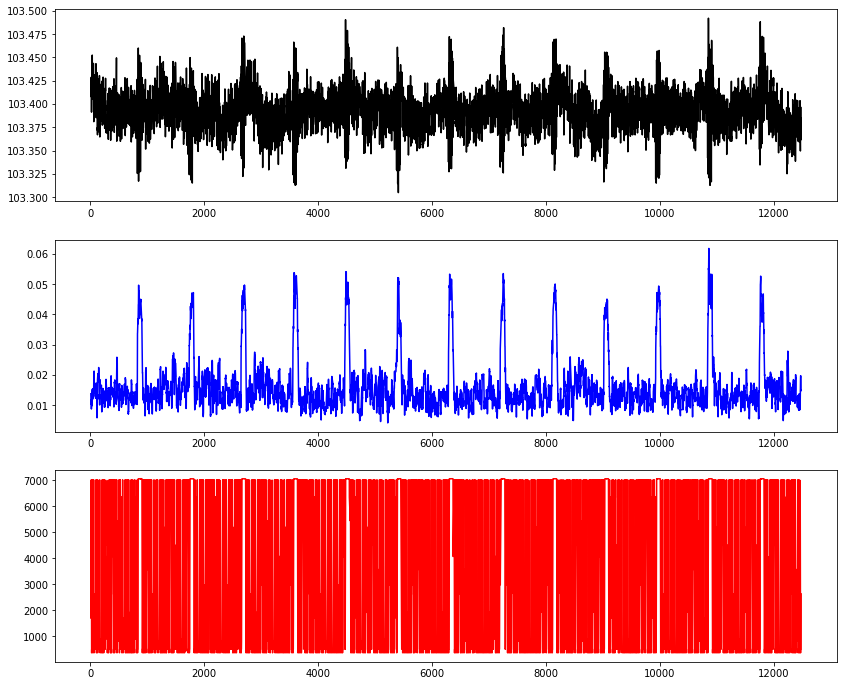

In [5]:
fig, axs = plt.subplots(3,figsize=(14,12))
bvimin = axs[0].plot(df['B:VIMIN'][0:10000], color='black', label='B:VIMIN Resampled values')
bvimin_std = axs[1].plot(df['B:VIMIN_STD'][0:10000], color='blue', label='B:VIMIN Rolling Std')
iib = axs[2].plot(df['I:IB'][0:10000], color='red', label= 'I:IB')

#mean = axs[1].plot(df['B:VIMIN_MEAN'][0:10000], color='red', label='Rolling Mean')

In [6]:
## CHOOSE VARIABLES ##
vars_in_question = ['B:VIMIN', 'B:VIMIN_STD', 'I:IB']

## NORMALIZE DATA ##
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

dataset = df[vars_in_question].values #numpy.ndarray
dataset = dataset.astype('float32')
#dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## CREATE DATASET ##
def create_dataset(dataset, look_back=1,look_forward=1):
    all_variable_x = []
    all_variable_y = []

    xxx = []
    yyy = []

    X = pd.DataFrame()
    Y = pd.DataFrame()
    offset = look_back+look_forward

    for j in range(0, len(vars_in_question)):
      for i in range(len(dataset)-(offset+1)):
          xx = dataset[i:(i+look_back), j] #grabs 2000 values
          yy = dataset[(i + look_back):(i + offset), j] #grab next 200 values
          
          xxx.append(xx)
          yyy.append(yy)

      all_variable_x.append(xxx)
      all_variable_y.append(yyy)
    
    return np.array(all_variable_x), np.array(all_variable_y)

look_back    = 2000
look_forward = 200 ## 1 second (cycle - 15Hz)

X, Y = create_dataset(dataset, look_back, look_forward)

In [7]:
## KFOLD SAMPLING ##
kf = KFold(n_splits = 5, random_state = True, shuffle = True)

train = []
test = []

for train_index, test_index in kf.split(X[1]):
  print("TRAIN:", train_index, "TEST:", test_index)
  train.append(train_index)
  test.append(test_index)

TRAIN: [    0     1     2 ... 71147 71148 71150] TEST: [   10    12    19 ... 71141 71146 71149]
TRAIN: [    0     1     3 ... 71148 71149 71150] TEST: [    2     8    13 ... 71140 71144 71147]
TRAIN: [    0     1     2 ... 71147 71148 71149] TEST: [    3    11    24 ... 71136 71142 71150]
TRAIN: [    1     2     3 ... 71147 71149 71150] TEST: [    0     4     5 ... 71143 71145 71148]
TRAIN: [    0     2     3 ... 71148 71149 71150] TEST: [    1     9    15 ... 71131 71133 71135]


In [8]:
import keras 
from keras.optimizers import  SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GaussianNoise
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
keras.backend.clear_session()

Using TensorFlow backend.


In [9]:
print(X.shape)
print(Y.shape)

(3, 71151, 2000)
(3, 71151, 200)


In [ ]:
# # reshape input to be [samples, features, time_steps]

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for i in range(0, len(train)):
  X_train = np.reshape(X[:, train[i], :], (X[:, train[i], :].shape[1], X.shape[0], X.shape[2]))
  X_test = np.reshape(X[:, test[i], :], (X[:, test[i], :].shape[1], X.shape[0], X.shape[2]))
  Y_train = Y[0, train[i], :]
  Y_test = Y[0, test[i], :]

  model = Sequential()
  model.add(LSTM(256, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(GaussianNoise(0.1))
  #model.add(Dropout(0.2))
  model.add(LSTM(256, return_sequences=True))
  model.add(GaussianNoise(0.1))
  #model.add(Dropout(0.2))
  model.add(LSTM(256))
  model.add(GaussianNoise(0.1))
  model.add(Dense(look_forward))
  opt = Adam(lr=1e-4)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
  model.summary()

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  from keras.callbacks import ReduceLROnPlateau, EarlyStopping
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6,verbose=1)
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

  history = model.fit(X_train, Y_train, epochs=50, batch_size= len(X_train), validation_split=0.2,
                      callbacks=[reduce_lr], verbose=1, shuffle=True)

  # Generate generalization metrics
  scores = model.evaluate(X_test, Y_test, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no += 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')

  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3, 256)            2311168   
_________________________________________________________________
gaussian_noise_16 (GaussianN (None, 3, 256)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 256)            525312    
_________________________________________________________________
gaussian_noise_17 (GaussianN (None, 3, 256)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 256)               525312    
_________________________________________________________________
gaussian_noise_18 (GaussianN (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)              

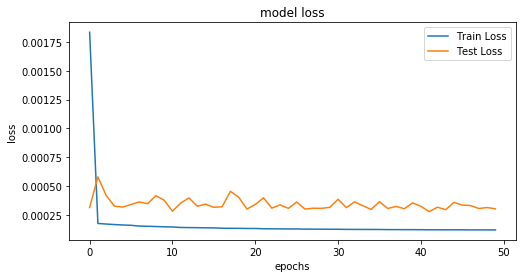

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
X_test = X_train
Y_test = Y_train
test_predict = model.predict(X_test)

In [ ]:
ntest_samples = len(X_test)
print(X_test.shape)
print(Y_test.shape)
print(test_predict.shape)
print('ntest_samples:',ntest_samples)
#fig, axs = plt.subplots(2,figsize=(24,20))
for i in range(ntest_samples):#ntest_samples-look_forward):
    plt.clf()
    #c_step = (i)*look_back
    #n_step = (i+1)*look_back
    #print('i',i)
    #print('c_step',c_step)
    #print('n_step',n_step)
    this_tx = np.concatenate((X_test[i][0].flatten(), Y_test[i].flatten()), axis=0)#[0:look_back+look_forward]
    #print(this_tx.shape)
    offset = X_test[i][0].copy()
    offset[:] = 0
    this_px = np.concatenate((offset.flatten(), test_predict[i].flatten()), axis=0)#[0:look_back+look_forward]
    plt.axvline(x=look_back,color='black',linewidth=2)
    plt.plot(this_tx, color='black',label='data',linewidth=2)
    plt.plot(this_px, '--', color='red',label='data+prediction',linewidth=2)
    plt.xlim(int(0),look_back+look_forward)
    plt.ylim(0.01,1.15)
    plt.axvspan(0, look_back, alpha=0.10, color='gray')
    plt.axvspan(look_back, look_back+look_forward, alpha=0.10, color='red')
    plt.annotate('Input data', xy=(0.05, 0.9), xycoords='axes fraction')
    plt.annotate('Predictions', xy=(0.8, 0.9), xycoords='axes fraction')
    ## Diff
    #this_px_diff = np.concatenate((X_test[c_step][0].flatten(), test_predict[c_step].flatten()), axis=0)[0:look_back+look_forward]
    #diff = this_px_diff - this_tx 
    #plt.savefig('test_results/test_prediction_{}.png'.format(i))
    plt.show()

(754623, 1, 2000)
(754623, 200)
(754623, 200)
ntest_samples: 754623
